#### Projecting Lat Long into a planner map

In [83]:
import numpy as np
import pandas as pd
import utm
import shapely as sph
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# Using the UTM package 
# for lat,lon in 
# Note: utm function takes input param1:latitude, param2:longitude
print (utm.from_latlon(11.1, -80.2))
print (utm.from_latlon(11.1345, -80.11))
print (utm.from_latlon(11.2, -81.0))

# Using Geopandas:
dataIN = pd.DataFrame({'longitude': [-80.2, -80.11, -81.0], 'latitude': [11.1, 11.1345, 11.2]})
dataIN
s = gpd.GeoSeries([Point(x,y) for x, y in zip(dataIN['longitude'], dataIN['latitude'])])
s
geo_df = gpd.GeoDataFrame(geometry=s)   # Is Similar to doing SpatialDataFrame in R
geo_df
geo_df.crs = {'init': 'epsg:4326'}      # Initialize what type of CRS 

geo_df = geo_df.to_crs({'init': 'epsg:3395'}) # Convert into a new CRS, similar to doing 
geo_df
# The Equivallent R code for the above function would be :
# out <- spTransform(dataIN_Spatial_DF, CRS=CRS("+init=epsg:3395 +proj=merc +ellps=WGS84"))

(587368.1295072659, 1227153.9499450792, 17, 'P')
(597186.3160143532, 1230997.0010059343, 17, 'P')
(500000.0, 1238093.672948581, 17, 'P')


,geometry
0,POINT (-8927823.161620541 1235228.11420853)
1,POINT (-8917804.407449147 1239116.84994171)
2,POINT (-9016878.754255159 1246501.097746004)


## Manipulating Data Frames and Plotting with GeoPandas:
----------

#### Part-1: Shape Plots (Polygoan Data):

(177, 6)
       continent  gdp_md_est  \
0           Asia     22270.0   
1         Africa    110300.0   
2         Europe     21810.0   
3           Asia    184300.0   
4  South America    573900.0   

                                            geometry iso_a3  \
0  POLYGON ((61.21081709172574 35.65007233330923,...    AFG   
1  (POLYGON ((16.32652835456705 -5.87747039146621...    AGO   
2  POLYGON ((20.59024743010491 41.85540416113361,...    ALB   
3  POLYGON ((51.57951867046327 24.24549713795111,...    ARE   
4  (POLYGON ((-65.50000000000003 -55.199999999999...    ARG   

                   name     pop_est  
0           Afghanistan  28400000.0  
1                Angola  12799293.0  
2               Albania   3639453.0  
3  United Arab Emirates   4798491.0  
4             Argentina  40913584.0  


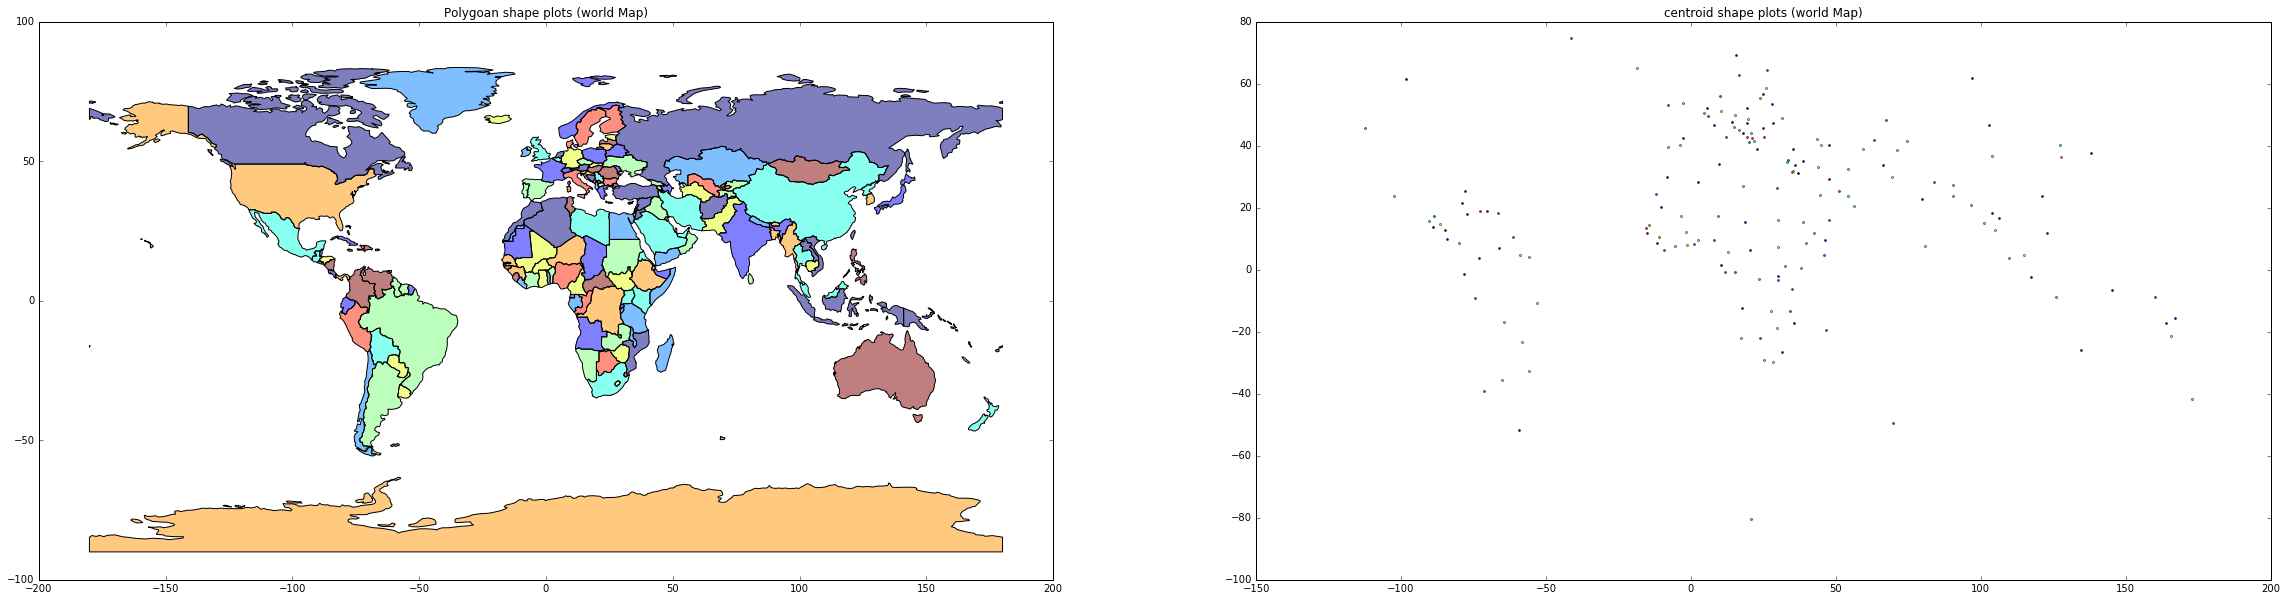

In [75]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print (world.shape)
print (world.head())

# To get the name of the coordinate column
world.geometry.name

# Set a Frame for the plot
fig, ax = plt.subplots(1,2, figsize=(40,10))

# To rename the column to boder instead of geometry and then set it as the coordinate/geometry column
world = world.rename(columns={"geometry": "borders"}).set_geometry('borders')
world.plot(ax=ax[0])
ax[0].set_title('Polygoan shape plots (world Map)')

# Now that our column "borders" is defined as the geometry column, we can do all
# geopandas operations on the Dataframe and only the border column will be affected by it.

# Lets us create a new column "centroid" that finds the center point of the polygoan area
world["centroid"] = world.centroid
# We have to set the centroid column as geometry to perform geopandas operations
world = world.set_geometry('centroid')
world.plot(ax=ax[1])
ax[1].set_title('centroid shape plots (world Map)')

#### **A Choropleth map : **

A choropleth map is a thematic map (with a certain theme) in which are are shaded or patterend in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per capita income.

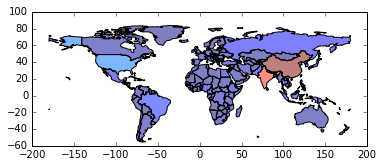

In [27]:
# Now we plot a map where the regions are colored based on the population residing at that part.
worldNew = world[(world.pop_est > 0) & (world.name != 'Antarctica')]
# Setting the geometry column again to borders for the new dataFrame to avoid centroid plots every time
worldNew = worldNew.rename(columns={"geometry": "borders"}).set_geometry('borders')
worldNew.plot(column='pop_est')

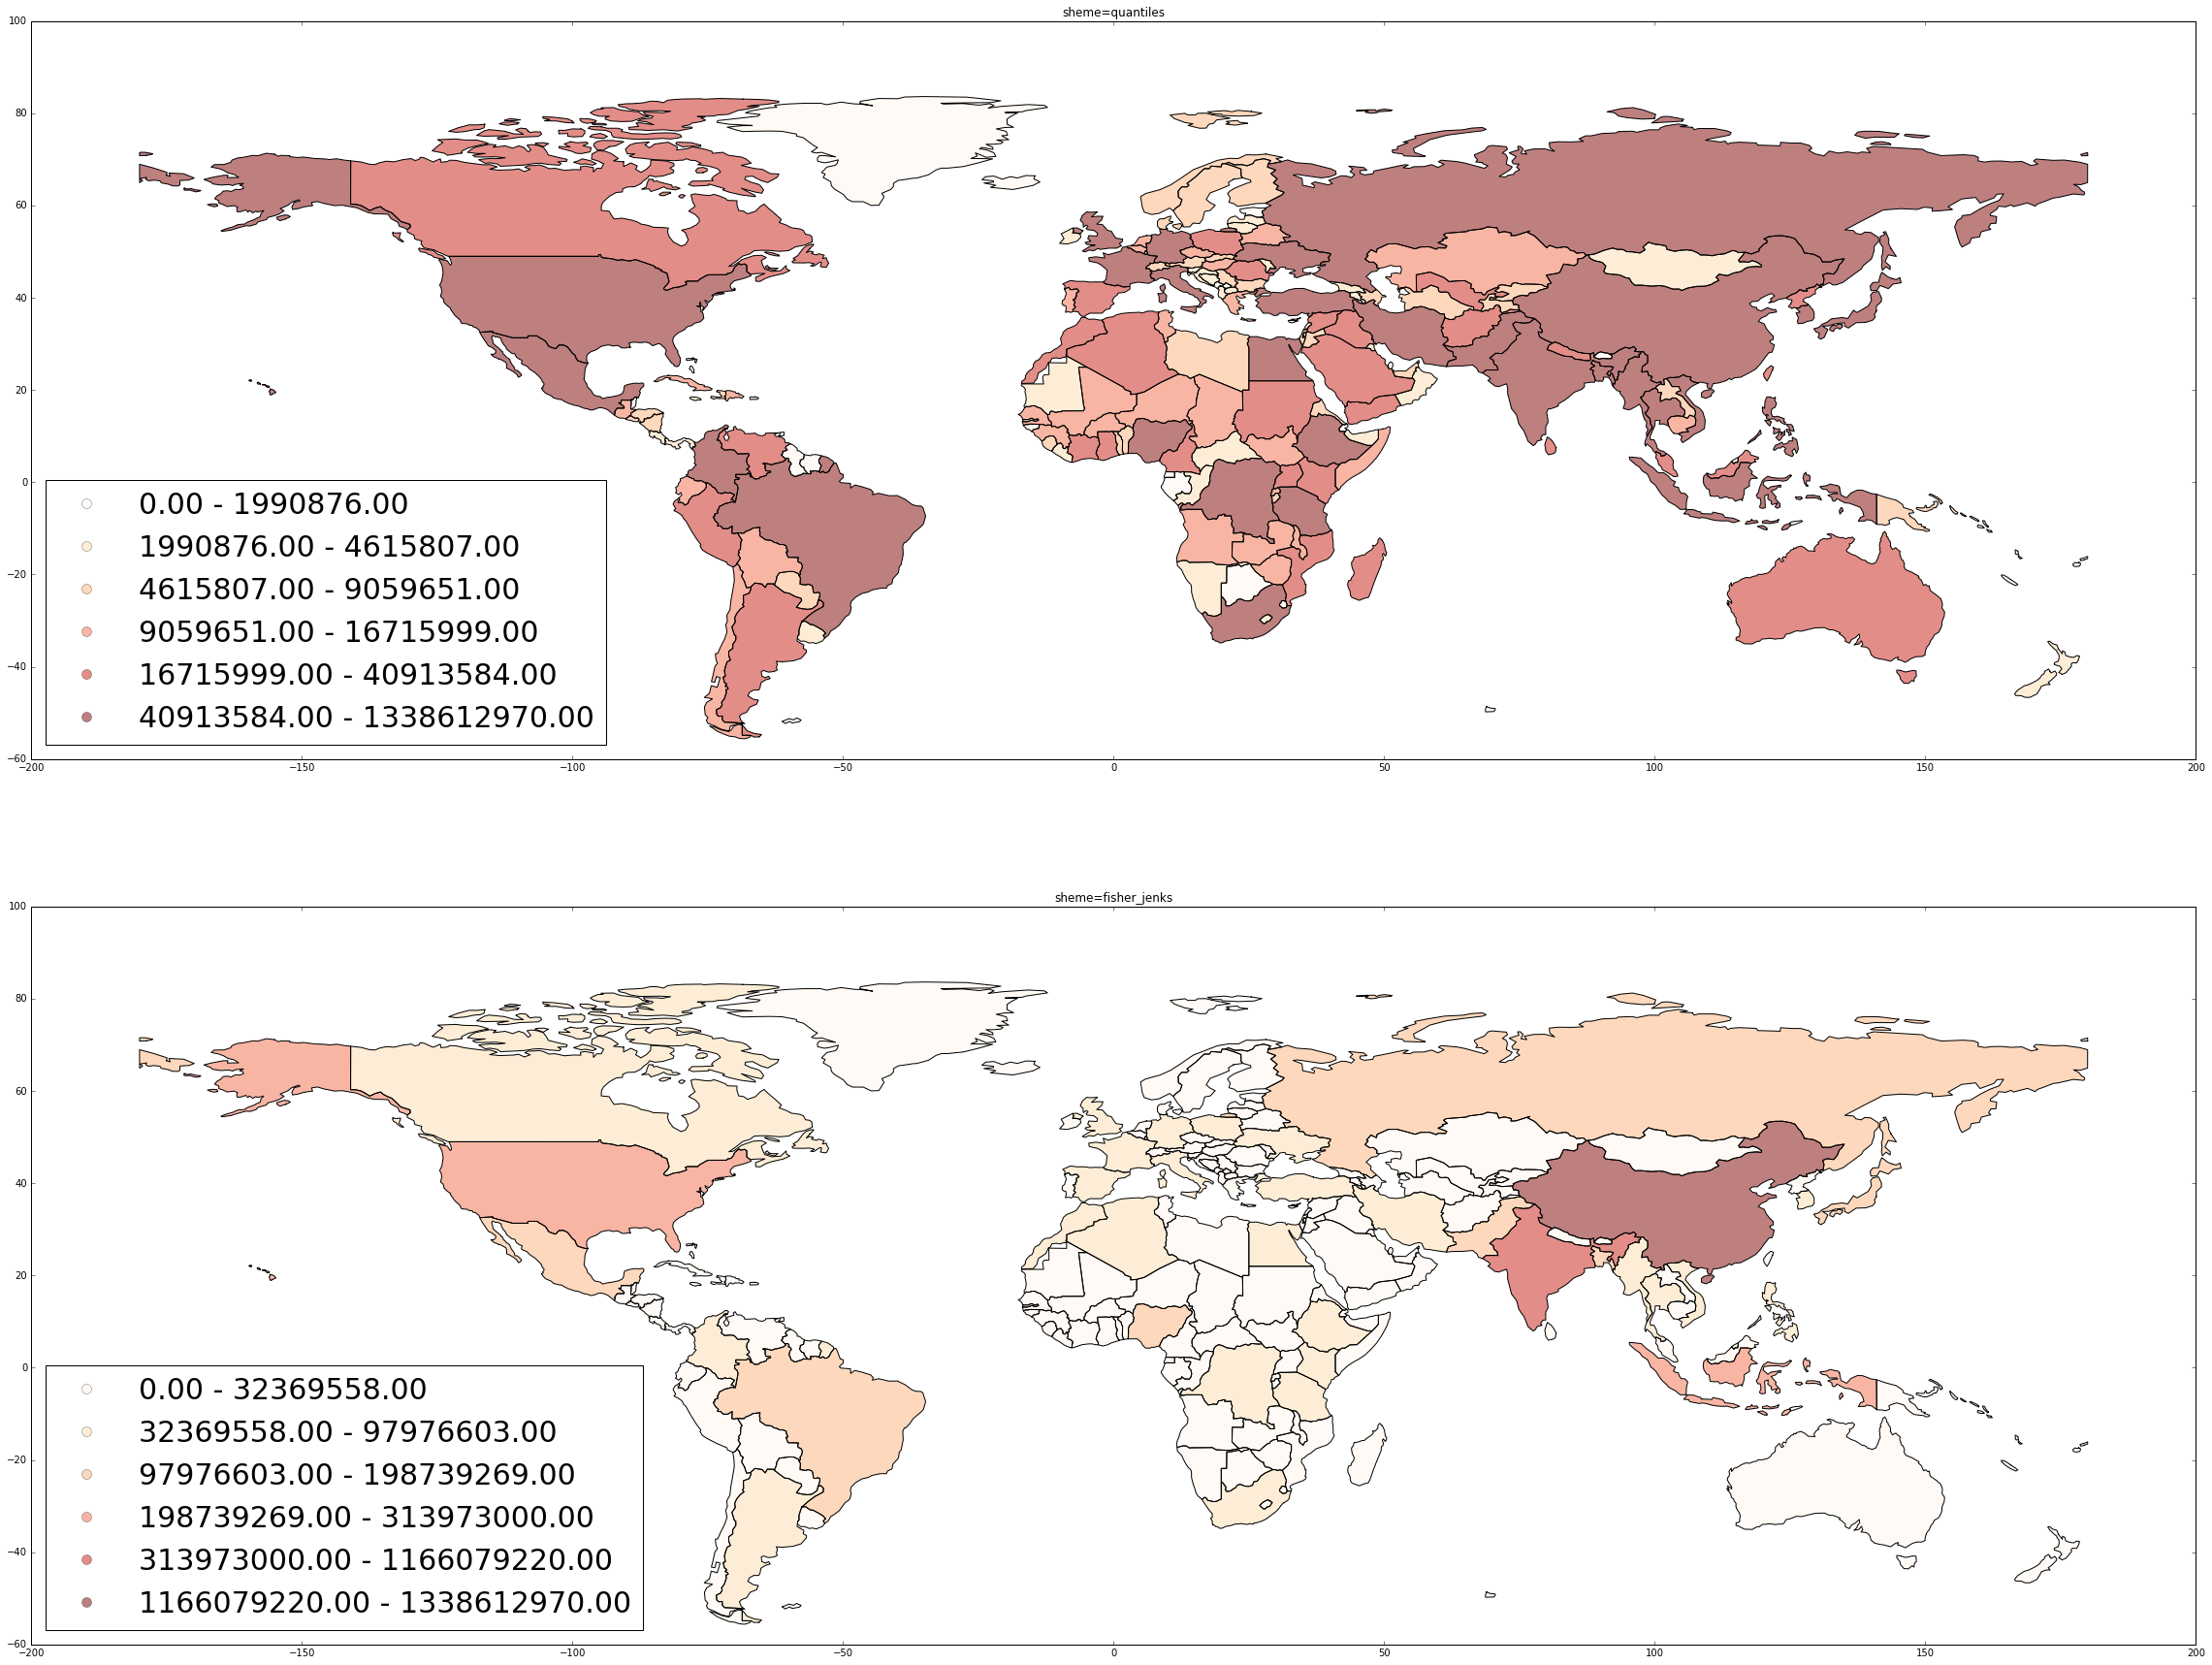

In [77]:
kw = dict(column='pop_est', k=6, cmap='OrRd')

fig, ax = plt.subplots(2,1, figsize=(40,30))
worldNew.plot(ax=ax[0], scheme='quantiles', **kw, legend=True); 
worldNew.plot(ax=ax[1], scheme='fisher_jenks', **kw, legend=True);
# A classification scheme is the product of arranging things
# into kinds of things (classes) or into groups of classes

leg0 = ax[0].get_legend()
leg0.set_bbox_to_anchor((0, 0, 1, 1))  # (left, bottom, width, height)
ax[0].set_title('sheme=quantiles')

leg1 = ax[1].get_legend()
leg1.set_bbox_to_anchor((0, 0, 1, 1))
ax[1].set_title('sheme=fisher_jenks')

#### Part-2: Point Plot (Lat, Long):

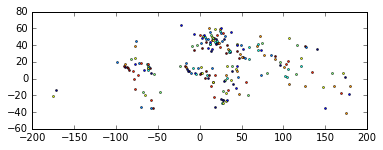

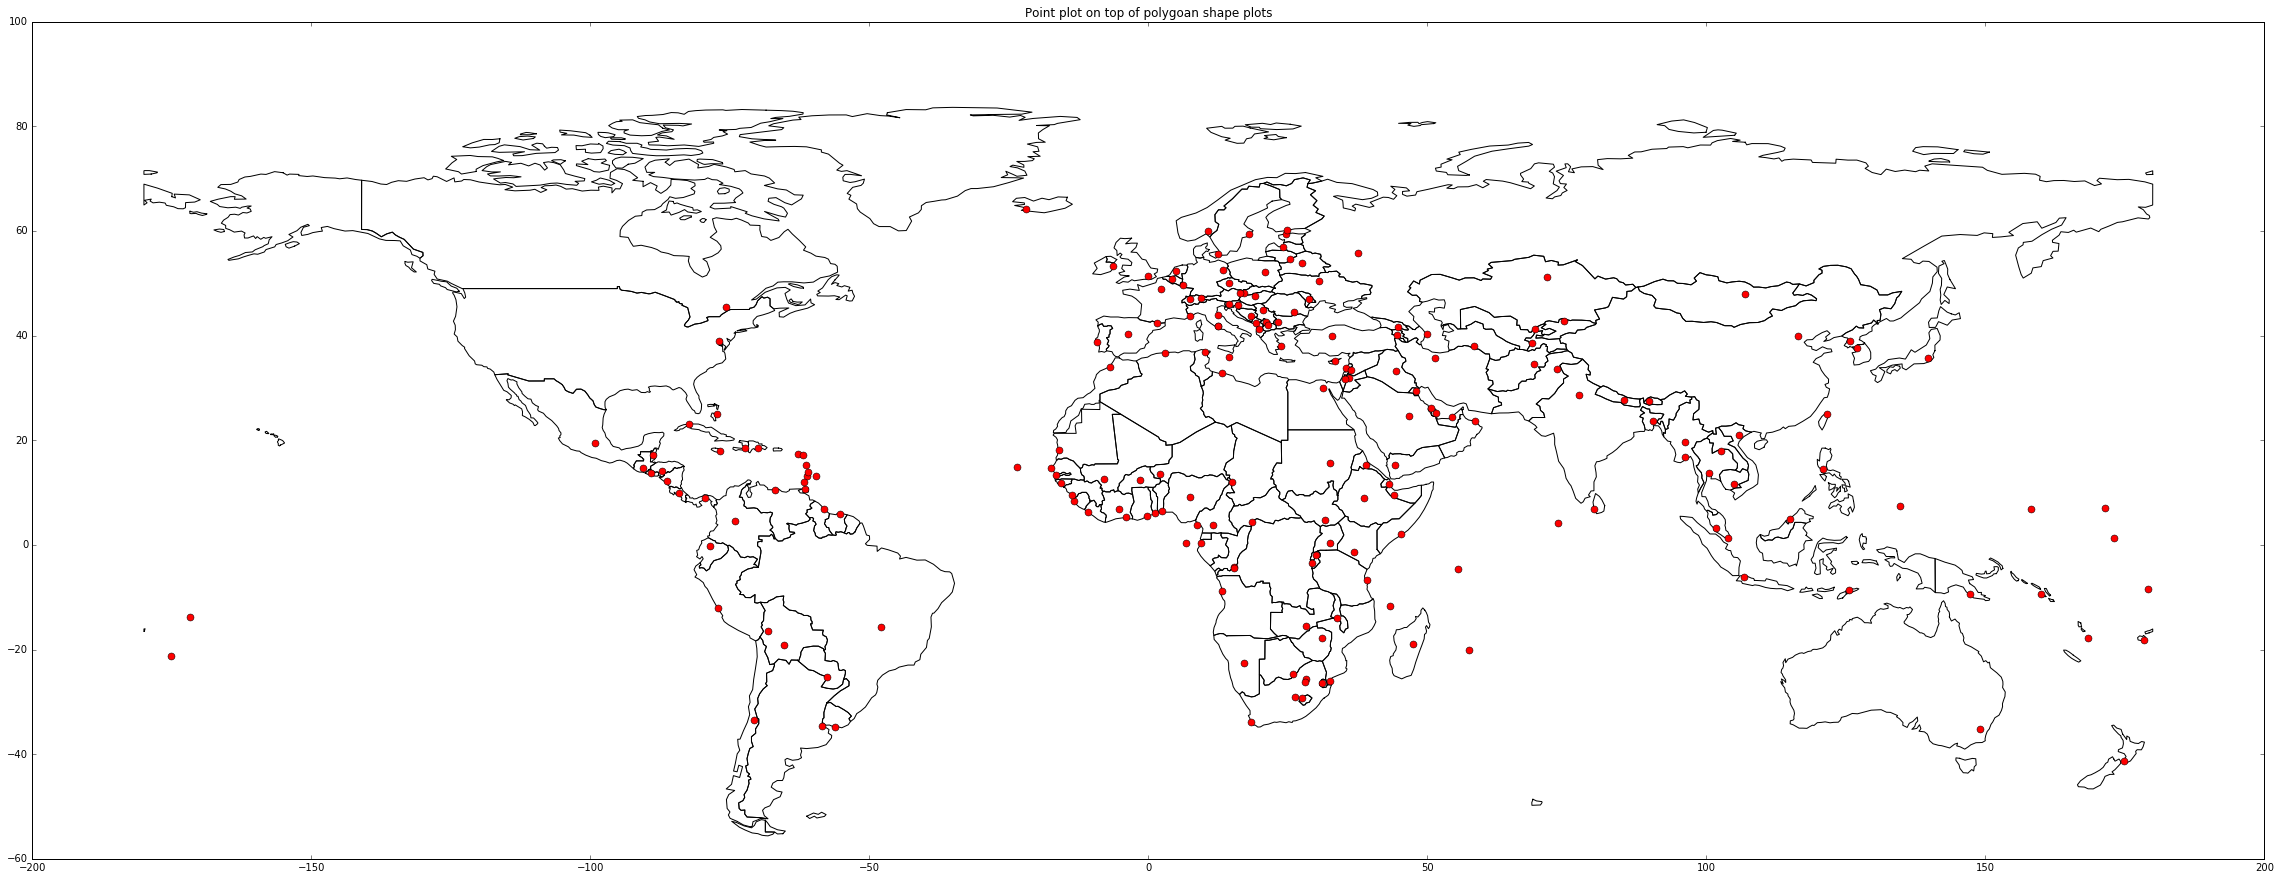

In [76]:
# Get the latitude and longitude data for the 
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities.head()

# Renaming the geometry column to latlong
cities.rename(columns={'geometry' : 'latlong'})
cities.plot()

# This aint that of a very good plot, 
# Let us now plot the points on top of the world map

# Step 1: Set a figure
fig, ax = plt.subplots(1,1, figsize=(40,15))

# Step 1: Set a base plot
basePlot = worldNew.plot(ax=ax, color='white') # we give white color so that the points are easily visible on the world map

# Step 2: Plot the points on top of the base plot
cities.plot(ax=basePlot, marker='o', color='red', markersize=7);
ax.set_title('Point plot on top of polygoan shape plots')

## Projections with GeoPandas:
------------

CSR type for the world map :  {'init': 'epsg:4326'}


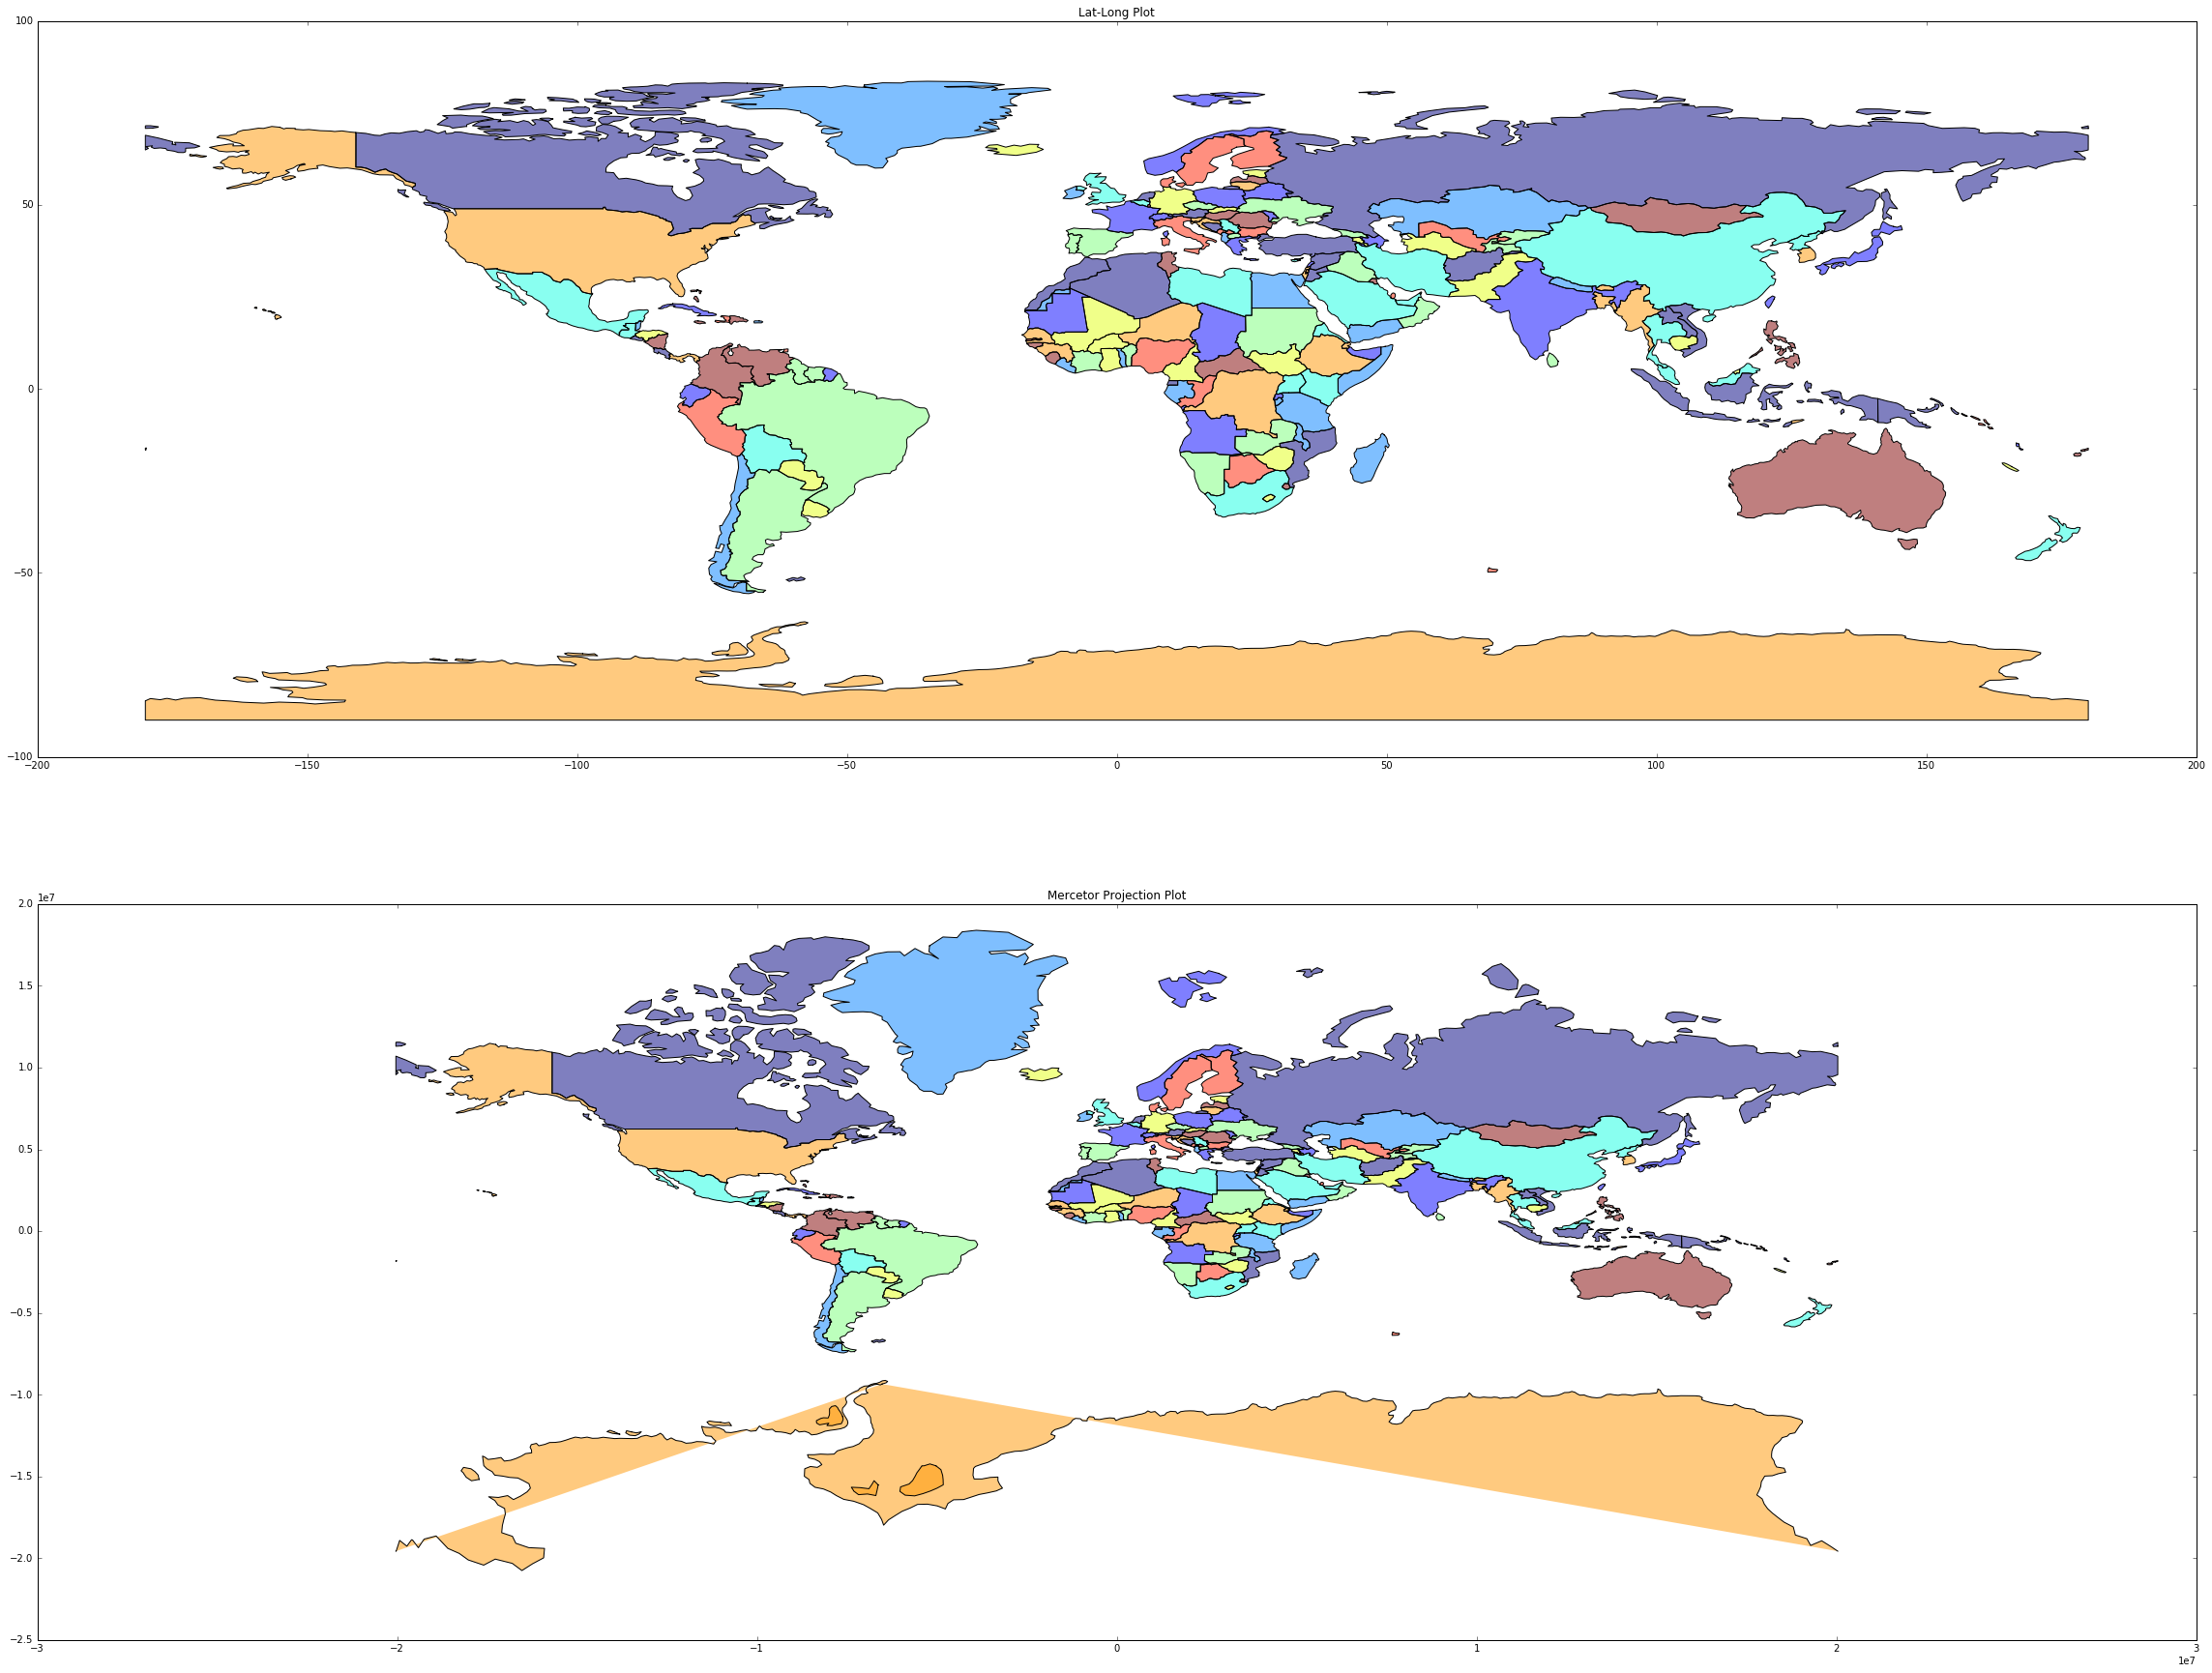

In [79]:
# Reload the data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Check the Type of Coordiante reference system (CRS)
csrType = world.crs
print ('CSR type for the world map : ', csrType)

# We see that the polygoans points are of EPSG:4326 which is latitude and longitude coordinate system
# Now we reproject them to Mercator (in Km). basically we project the latlong points onto a plane
world_merc = world.to_crs({'init': 'epsg:3395'})

# Plot both the projections (latlong and mercetor)
fig, ax = plt.subplots(2,1, figsize=(40,30))
world.plot(ax=ax[0])
world_merc.plot(ax=ax[1])
ax[0].set_title('Lat-Long Plot')
ax[1].set_title('Mercetor Projection Plot')

## Geometric Manipulation:
----------

The GeoPandas API provides all different types of geometric manipulation provided by the ***shapely library***. Some of them are given as :
  * Points (methods : {area, bounds, coords})
  * LineString (methods : {bounds, coords})
  * LineRing (methods : {area, length, bounds, coords})
  * Polygoans (methods : {area, length, bounds, coords})
  * MultiPoint (methods : {area, length, bounds, coords})
  * Other manipulations : intersection, union, centroid, difference etc.......

GeoPandas invokes two Classes where we can combine different shapes and put it into a Data Frame.

 * GeoSeries
 * GeoDataFrame

#### GeoSeries:

In many application we wont get inputs as shapes but list of coordinate points, GeoSeries helps to convert such coordinates into shapes that are inderstood by GeoPandas and hence can be manipulated using all the methods of **Shapely**

In [98]:
# A simple Geometric projection
# First we define few polygoans

p1 = sph.geometry.Polygon([(0, 0), (1, 0), (1, 1)])
p2 = sph.geometry.Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = sph.geometry.Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])

# Now we create a Geometric Series using goepandas
gs = gpd.GeoSeries([p1,p2,p3])
print (gs)

# Now that gs is a GeoSeries object we can use all the relevant methods/variables 
# provided by the shapely library to manipulate the polygons shape
print ('The area each polygons is:\n', gs.area)
print ('The length each polygons is:\n',gs.length)
print ('The centroids of each polygons are:\n', gs.centroid)
print ('The convex_hull of each polygons are:\n', gs.convex_hull)
# gs.plot()

0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object
The area each polygons is:
 0    0.5
1    1.0
2    1.0
dtype: float64
The length each polygons is:
 0    3.414214
1    4.000000
2    4.000000
dtype: float64
The centroids of each polygons are:
 0    POINT (0.6666666666666666 0.3333333333333333)
1                                  POINT (0.5 0.5)
2                                  POINT (2.5 0.5)
dtype: object
The centroids of each polygons are:
 0         POLYGON ((0 0, 1 1, 1 0, 0 0))
1    POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))
2    POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))
dtype: object


#### GeoDataFrame:

GeoDataFrames helps in many ways, 1) It says GeoPandas that a particular Series or Input is a GeoDataFrame, so that one input column can be treated as the geometry column and all **GeoPandas/Shapely** operation can be done on the column. 2) When we load a dataset from disk it is always good to store the input in a DataFrame so that we can perform all small sql like manipulations we desire.